# Preliminaries

In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from kneed import KneeLocator


plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [2]:
#Load original dataframes
allDataOrig = pd.read_csv("../Data/Original DataFrames/AllDataSingleValue.csv", sep=",", index_col='DEIDNUM') #all feature dataset
hemoOrig = pd.read_csv("../Data/Original DataFrames/HemoSingleValue.csv", sep=",", index_col='DEIDNUM') #dataset with only hemodynamics
classLabels  = pd.read_csv("../Data/Original DataFrames/Labels.csv", sep=",", index_col='DEIDNUM') #labels for prediction classes 

In [ ]:
# first - try other clustering methods

# Cluster Labels

In [3]:
#CLUSTERING FUNCTIONS
def clusterFindK(X): #find optimal num k
    sum_of_squared_distances = []
    silhouette = []
    K = range(1,16)
    for k in K:
        k_means = KMeans(n_clusters=k, init='k-means++',n_init=50, max_iter=500, tol=1e-04, random_state=0)
        model = k_means.fit(X)
        sum_of_squared_distances.append(k_means.inertia_)
        if k != 1:
            silhouette.append(silhouette_score(X, k_means.labels_))
        

    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('K Number of Clusters')
    plt.ylabel('Sum of Squared Error')
    plt.title('Elbow Method to Find Optimal K')
    plt.show()
    
    kl = KneeLocator(K, sum_of_squared_distances, curve="convex", direction="decreasing")
    print("Using the elbow method, the optimal number of clusters is", kl.elbow)
    
    plt.plot(range(2,16), silhouette)
    plt.xlabel("K Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()
    
    print("Using Silhouette Scores, the optimal number of clusters is", silhouette.index(max(silhouette))+2)
    
def kMeans(X, K): #perform k means clustering
    km = KMeans(n_clusters=K, init='k-means++',n_init=50, max_iter=500, tol=1e-04, random_state=0)
    y_km = km.fit_predict(X)
    print("Lowest SSE", km.inertia_) #lowest sum of squared error value
    print("Number of iterations needed for convergence", km.n_iter_) #number of iterations neded to converge
    print("Y_km labels", y_km)
    
    return y_km, km

def plotPCAClusters(X, y_km, K, name): #plot clusters from pca
    df = pd.DataFrame(X, columns=["Component_1", "Component_2"])
    df['Cluster'] = y_km + 1
    plt.figure(figsize=(16,7))
    sns.scatterplot(x='Component_1', y='Component_2', hue='Cluster', palette=sns.color_palette('hls', K), data=df, legend='full')
    plt.title("Resulting Score Clusters")
    plt.savefig("Figures/Score_Clusters_" + name + ".png")

    plt.show()
    
    return df

def plotClusters(X, y_km, columns, K): #plot original data clusters
    X['cluster'] = y_km
    plt.figure(figsize=(16,7))
    sns.scatterplot(x=columns[0], y=columns[1], hue='cluster',palette=sns.color_palette('hls', K), data=X, legend='full')
    plt.show()
    
    return X

def compareClusters(dt, K): #compare details of clusters
    clusters = []
    clusterDesc = []
    for num in range(K):
        cls = dt[dt['cluster'] == num]
        clusters.append(cls)

        print("Cluster ", num)
        print(cls.describe())
        clusterDesc.append(cls.describe())
        
    return clusters, clusterDesc

#compare distributions of clusters
def distPlotsForClusters(cls, cols, name):
    clusters = copy.deepcopy(cls)
    for c in cols:
        f, ax = plt.subplots(figsize=(11,9))
        for i in range(len(clusters)):
            currCls = pd.DataFrame(clusters[i])
            currCls = currCls.replace(np.inf, 0)
            sns.distplot(currCls[c], ax=ax, label=i)
        
        plt.title(c+ ' Distribution by Cluster')
        plt.ylabel("Distribution Value")
        plt.legend(title="Cluster")
        
        plt.savefig("Figures/" + name + "/Clusters"+c+".png")

## Hemo Dataset

In [4]:
#try clustering to find similar groups using PCA
hemo = copy.deepcopy(hemoOrig)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)
scaler = MinMaxScaler()#scale data
hemo.loc[:,:] = scaler.fit_transform(hemo)
pca = PCA(n_components=2)
data = pca.fit_transform(hemo)

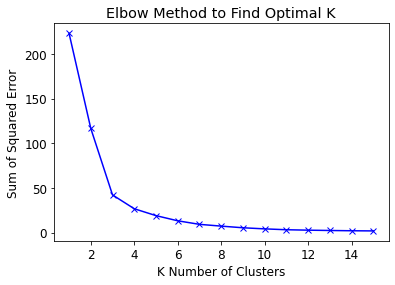

Using the elbow method, the optimal number of clusters is 3
Using Silhouette Scores, the optimal number of clusters is 3


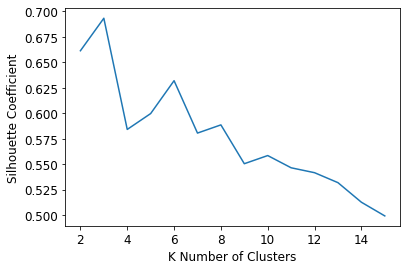

In [5]:
clusterFindK(data)

Lowest SSE 18.899258824259796
Number of iterations needed for convergence 4
Y_km labels [1 1 4 4 4 4 1 2 4 4 0 4 4 3 2 2 4 3 1 1 4 4 1 1 1 1 0 3 1 1 4 3 4 4 0 0 0
 0 4 4 0 4 0 0 4 4 0 0 4 4 4 4 4 3 0 4 0 0 0 4 4 4 0 3 1 1 4 4 1 2 1 1 0 3
 0 3 0 4 0 4 1 1 0 4 1 1 1 1 1 1 4 4 4 4 3 4 0 3 4 4 4 4 0 4 4 4 4 4 0 4 4
 4 0 3 0 0 1 1 2 1 0 4 4 4 0 0 4 4 0 4 1 1 1 1 1 1 0 4 1 1 0 0 1 1 0 4 4 4
 1 1 4 4 0 0 0 3 1 2 4 4 1 2 0 4 0 0 0 4 0 3 0 4 1 1 4 0 0 4 0 0 0 0 4 4 1
 1 0 4 0 4 1 1 2 1 4 4 0 0 0 0 4 4 0 4 4 4 0 4 4 4 4 4 1 1 0 4 1 1 0 4 1 1
 0 3 1 1 4 4 0 4 0 4 0 4 4 3 1 1 4 4 1 1 1 1 2 2 1 1 4 3 1 1 4 4 4 3 4 4 0
 0 0 4 4 4 0 4 0 3 2 1 4 4 0 4 0 0 4 4 1 1 4 4 0 4 4 4 0 4 4 4 4 4 0 0 4 4
 4 4 0 4 0 4 0 0 0 4 0 0 0 0 1 1 1 1 4 4 0 0 1 1 1 1 0 3 0 0 1 1 0 0 0 4 0
 3 0 3 1 1 0 0 4 4 0 0 1 1 2 2 0 4 1 1 4 4 4 4 1 1 0 3 4 4 1 1 0 3 4 0 0 4
 4 0 4 4 0 0 0 4 1 1 0 4 1 1 4 4 4 0 4 4 0 0 0 4 0 4 4 0 3 4 4 4 0 0 4 4 4
 3 1 1 0 4 4 3 0 0 1 1]


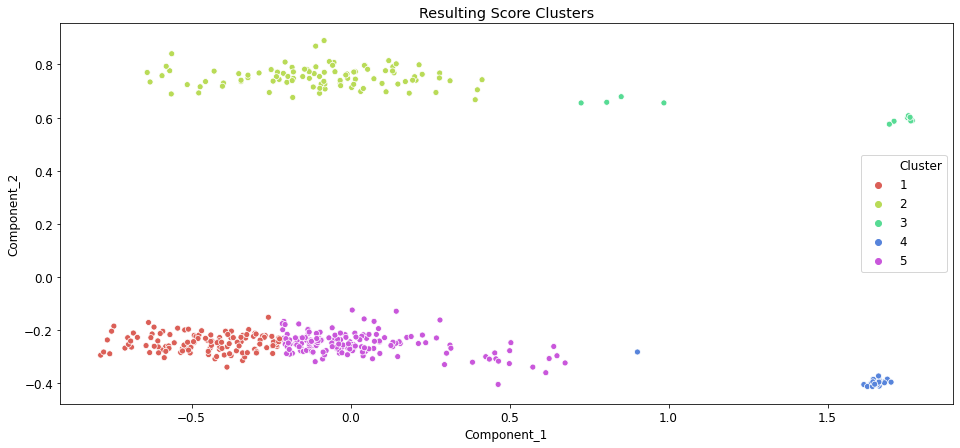

In [6]:
y_km, model = kMeans(data, 5)

#Save cluster model
pickle.dump(model, open('ClusterModels/HemoCluster.sav', 'wb'))

pcaDF = plotPCAClusters(data, y_km, 5, "Hemo")

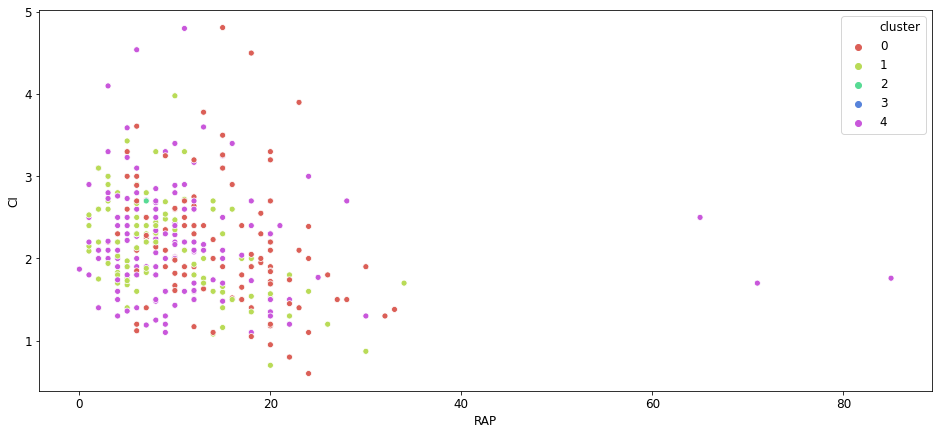

In [7]:
#Look at original data clusters
hemoDF = plotClusters(hemoOrig, y_km, ["RAP", "CI"], 5)

In [8]:
#Add class labels
hemoDF['Death'] = classLabels['Death']
hemoDF['Rehosp'] = classLabels['Rehosp']
hemoDF['Readmission'] = classLabels['Readmission']

clusters, clusterDesc = compareClusters(hemoDF, 5)

Cluster  0
              Age  Gender        Race         EjF        RAP         PAS  \
count  120.000000   120.0  120.000000  118.000000  118.00000  120.000000   
mean    55.383333     1.0    2.441667   18.110169   14.59322   62.883333   
std     12.146295     0.0    8.849627    6.943956    6.55188   11.466563   
min     23.000000     1.0    1.000000    0.000000    2.00000   31.000000   
25%     46.000000     1.0    1.000000   15.000000   10.00000   54.750000   
50%     56.000000     1.0    1.000000   17.000000   14.00000   64.000000   
75%     64.000000     1.0    2.000000   20.000000   20.00000   70.000000   
max     78.000000     1.0   98.000000   40.000000   33.00000   90.000000   

              PAD        PAMN        PCWP          CO  ...         RAT  \
count  120.000000  118.000000  113.000000  119.000000  ...  111.000000   
mean    31.075000   42.364407   27.185841    4.404034  ...    0.548065   
std      8.538752    9.962893    9.110971    1.528561  ...    0.216457   
min     

In [11]:
#Save descriptive details from clusters

descSummary = pd.DataFrame()
for i in range(len(clusterDesc)):
    descSummary = descSummary.append(clusterDesc[i])
descSummary.to_csv("Cluster_Descriptions_Hemo.csv")

In [12]:
hemoDF.to_csv("Clustered_HemoDF.csv")

Save preprocessed data  
Cluster --> Score   

In [13]:
#Get means for each cluster

clsScDF = pd.DataFrame()
clsScDF.index.name = 'Cluster'

scores = [1,2,3,4,5]
dthMn = descSummary.loc['mean']['Death'].to_numpy()
rehospMn = descSummary.loc['mean']['Rehosp'].to_numpy()
readmMn = descSummary.loc['mean']['Readmission'].to_numpy()

In [14]:
dthScores = [0,0,0,0,0]
cnt = 0
for v in np.argsort(dthMn):
    dthScores[v] = scores[cnt]
    cnt += 1

rehospScores = [0,0,0,0,0]
cnt = 0
for v in np.argsort(rehospMn):
    rehospScores[v] = scores[cnt]
    cnt += 1

readmScores = [0,0,0,0,0]
cnt = 0
for v in np.argsort(readmMn):
    readmScores[v] = scores[cnt]
    cnt += 1
    
clsScDF['DeathMean'] = dthMn
clsScDF['DeathScores'] = dthScores
clsScDF['RehospMean'] = rehospMn
clsScDF['RehospScores'] = rehospScores
clsScDF['ReadmMean'] = readmMn
clsScDF['ReadmScores'] = readmScores

aveScores = []
for i in clsScDF.index:
    c = clsScDF.loc[i]
    a = c['DeathScores'] + c['RehospScores'] + c['ReadmScores']
    aveScores.append(a/3)

clsScDF['AveScores'] = aveScores
clsScDF

,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores
0,0.325000,3,0.566667,4,0.175000,4,3.666667
1,0.257732,1,0.546392,3,0.144330,1,1.666667
2,0.384615,4,0.538462,2,0.153846,2,2.666667
3,0.384615,5,0.423077,1,0.230769,5,3.666667
4,0.302469,2,0.586420,5,0.166667,3,3.333333


Make sure to add final scores assignment

In [15]:
#ADD HERE
finalScores = [4, 1, 2, 5, 3]
clsScDF['FinalScores'] = finalScores
clsScDF

,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores,FinalScores
0,0.325000,3,0.566667,4,0.175000,4,3.666667,4
1,0.257732,1,0.546392,3,0.144330,1,1.666667,1
2,0.384615,4,0.538462,2,0.153846,2,2.666667,2
3,0.384615,5,0.423077,1,0.230769,5,3.666667,5
4,0.302469,2,0.586420,5,0.166667,3,3.333333,3


In [16]:
#Save fully preprocessed score data
clusNums = hemoDF['cluster']

labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['FinalScores']))
hemoDF['Score'] = labels

#Death Scores
labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['DeathScores']))
hemoDF['ScoreDeath'] = labels

#Rehosp Scores
labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['RehospScores']))

hemoDF['ScoreRehosp'] = labels

#Readm Scores
labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['ReadmScores']))
hemoDF['ScoreReadmission'] = labels

hemoDF = hemoDF.drop(columns=["cluster"])
hemoDF = hemoDF.drop(columns=["Death"])
hemoDF = hemoDF.drop(columns=["Rehosp"])
hemoDF = hemoDF.drop(columns=["Readmission"])

hemoDF

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
DEIDNUM,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,25.0,24.0,42.0,24.0,30.0,36.0,2.20,...,0.666667,0.266667,0.750000,0.777778,50.0,1.166667,1,1,3,1
72,88.0,2.0,1.0,25.0,18.0,42.0,24.0,30.0,24.0,3.10,...,0.750000,0.272727,1.000000,1.000000,50.0,1.333333,1,1,3,1
81,69.0,1.0,1.0,20.0,10.0,40.0,20.0,27.0,18.0,4.52,...,0.555556,0.242857,2.000000,0.944444,45.0,1.700000,3,2,5,3
81,69.0,1.0,1.0,20.0,12.0,35.0,15.0,25.0,17.0,4.65,...,0.705882,0.571429,1.666667,2.352941,45.0,3.333333,3,2,5,3
814,58.0,1.0,1.0,NaN,3.0,51.0,19.0,30.0,18.0,4.10,...,0.166667,0.566667,10.666667,1.888889,44.0,11.333333,3,2,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98508,57.0,1.0,98.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,37.0,NaN,5,5,1,5
99302,41.0,1.0,2.0,15.0,19.0,87.0,37.0,54.0,44.0,3.90,...,0.431818,0.642857,2.631579,1.227273,13.0,2.842105,4,3,4,4
99302,41.0,1.0,2.0,15.0,11.0,70.0,28.0,44.0,28.0,5.30,...,0.392857,1.088608,3.818182,3.071429,13.0,7.818182,4,3,4,4


In [17]:
hemoDF.to_csv("../Data/Preprocessed Data/Cluster_Hemo.csv")

## All Data

In [18]:
#try clustering to find similar groups using PCA
allData = copy.deepcopy(allDataOrig)
allData = allData.replace(np.inf, 0)
allData = allData.fillna(0)
scaler = MinMaxScaler()#scale data
allData.loc[:,:] = scaler.fit_transform(allData)
pca = PCA(n_components=2)
data = pca.fit_transform(allData)

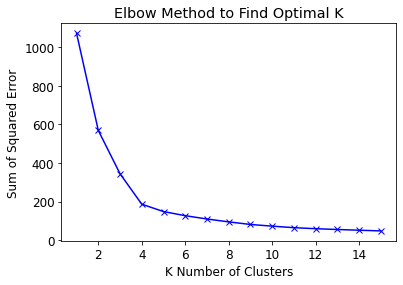

Using the elbow method, the optimal number of clusters is 4
Using Silhouette Scores, the optimal number of clusters is 4


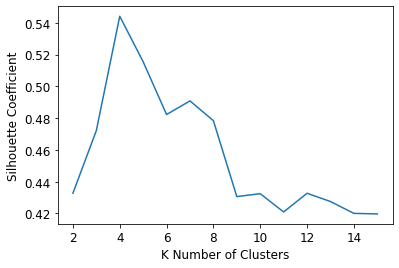

In [19]:
clusterFindK(data)

Lowest SSE 148.5845384599457
Number of iterations needed for convergence 8
Y_km labels [3 3 1 1 2 2 3 3 3 3 2 2 1 1 2 2 3 3 1 1 0 0 2 2 1 1 1 1 3 3 2 2 0 0 1 1 0
 0 1 1 0 0 2 2 3 3 2 2 1 1 3 3 2 2 4 4 3 3 0 0 3 3 3 3 3 3 4 4 3 3 3 3 3 3
 3 3 3 3 1 1 4 4 0 0 1 1 3 3 2 2 2 4 2 2 4 4 1 1 4 4 0 0 1 1 2 2 3 3 2 2 2
 2 2 2 1 1 3 3 3 3 3 3 1 1 2 2 2 2 3 3 0 0 2 2 2 2 2 2 0 0 2 2 2 2 3 3 3 3
 4 4 2 2 4 4 1 1 2 2 2 2 2 2 2 2 2 2 1 1 2 2 3 3 0 0 3 3 3 3 4 4 1 1 1 1 4
 4 2 2 2 2 3 3 4 4 1 1 1 1 1 1 1 1 1 1 3 3 1 1 3 3 1 1 4 4 0 0 0 0 0 0 0 0
 2 2 4 4 2 2 2 2 1 1 4 4 1 1 2 2 2 2 2 2 3 3 3 3 1 1 3 3 4 4 0 0 2 2 4 4 1
 1 2 4 3 3 1 1 0 0 2 2 0 0 4 4 0 0 4 4 3 3 0 0 3 3 2 2 3 3 1 1 3 3 1 1 2 2
 4 4 2 2 3 3 4 4 2 2 2 2 3 3 3 3 3 3 1 1 2 2 4 4 1 1 4 4 2 2 2 2 2 2 2 2 3
 3 3 3 1 1 3 3 3 3 1 1 1 1 2 2 1 1 4 4 4 4 2 2 0 0 0 0 1 1 1 1 0 0 4 4 2 2
 4 4 1 1 1 1 1 1 1 1 1 1 2 2 4 4 2 2 1 1 3 3 3 3 2 2 3 3 2 2 3 3 2 2 1 1 3
 3 3 3 0 0 2 2 2 2 0 0 3 3 2 2 2 2 4 4 1 1 2 2 2 2 2 2 0 0 2 2 1 1 0 0 4 4
 4 4 1 1 2 2 

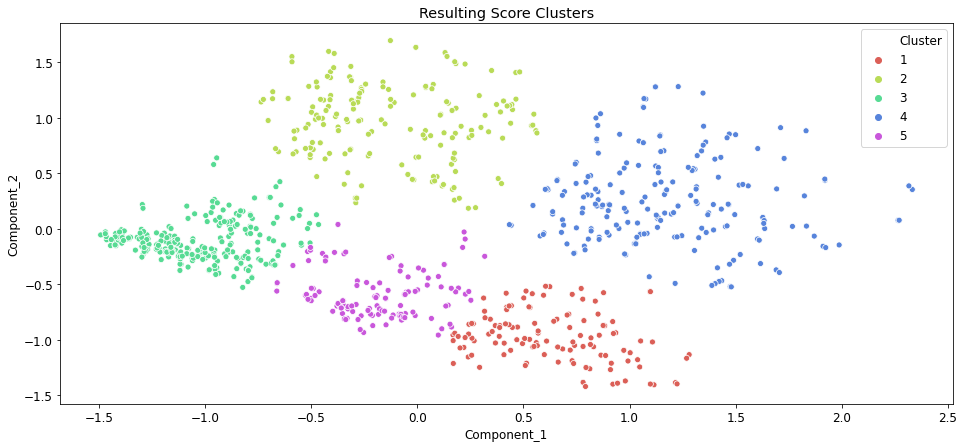

In [20]:
y_km, model = kMeans(data, 5)

#Save cluster model
pickle.dump(model, open('ClusterModels/AllDataCluster.sav', 'wb'))

pcaDF = plotPCAClusters(data, y_km, 5, 'AllData')

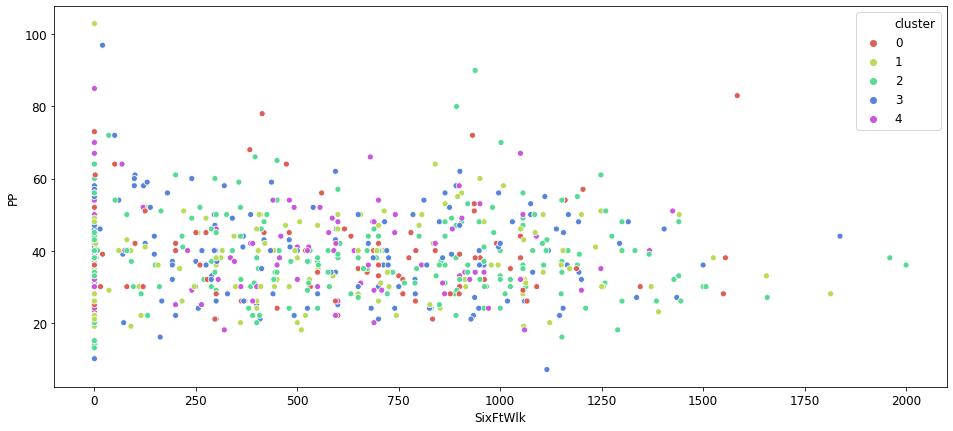

In [21]:
#Look at original data clusters
allDF = plotClusters(allDataOrig, y_km, ["SixFtWlk", "PP"], 5)

In [22]:
#Add class labels
allDF['Death'] = classLabels['Death']
allDF['Rehosp'] = classLabels['Rehosp']
allDF['Readmission'] = classLabels['Readmission']

clusters, clusterDesc = compareClusters(allDF, 5)

Cluster  0
              Age      Gender        Race          Wt         BMI  \
count  120.000000  120.000000  120.000000  112.000000  108.000000   
mean    61.341667    1.133333    3.166667   83.680601   28.273478   
std     11.585630    0.341360   12.444386   17.784618    5.358654   
min     40.000000    1.000000    1.000000   47.000000   18.242188   
25%     51.750000    1.000000    1.000000   68.925000   24.744351   
50%     60.000000    1.000000    1.000000   82.700000   27.644501   
75%     71.000000    1.000000    2.000000   93.775000   30.532587   
max     83.000000    2.000000   98.000000  134.000000   44.803003   

       InitialHospDays  TotalHospDays        NYHA       MLHFS     AF  ...  \
count       120.000000     120.000000  116.000000  118.000000  120.0  ...   
mean          8.741667      14.758333    3.387931   73.101695    0.0  ...   
std           6.084138      12.803621    0.682343   17.377847    0.0  ...   
min           0.000000       1.000000    2.000000   32.0000

In [25]:
#Save descriptive details from clusters

descSummary = pd.DataFrame()
for i in range(len(clusterDesc)):
    descSummary = descSummary.append(clusterDesc[i])
descSummary.to_csv("Cluster_Descriptions_AllData.csv")

In [26]:
allDF.to_csv("Clustered_allDataDF.csv")

Save preprocessed data  
Cluster --> Score   

In [27]:
#Get means for each cluster

clsScDF = pd.DataFrame()
clsScDF.index.name = 'Cluster'

scores = [1,2,3,4,5]
dthMn = descSummary.loc['mean']['Death'].to_numpy()
rehospMn = descSummary.loc['mean']['Rehosp'].to_numpy()
readmMn = descSummary.loc['mean']['Readmission'].to_numpy()

In [28]:
dthScores = [0,0,0,0,0]
cnt = 0
for v in np.argsort(dthMn):
    dthScores[v] = scores[cnt]
    cnt += 1

rehospScores = [0,0,0,0,0]
cnt = 0
for v in np.argsort(rehospMn):
    rehospScores[v] = scores[cnt]
    cnt += 1

readmScores = [0,0,0,0,0]
cnt = 0
for v in np.argsort(readmMn):
    readmScores[v] = scores[cnt]
    cnt += 1
    
clsScDF['DeathMean'] = dthMn
clsScDF['DeathScores'] = dthScores
clsScDF['RehospMean'] = rehospMn
clsScDF['RehospScores'] = rehospScores
clsScDF['ReadmMean'] = readmMn
clsScDF['ReadmScores'] = readmScores

aveScores = []
for i in clsScDF.index:
    c = clsScDF.loc[i]
    a = c['DeathScores'] + c['RehospScores'] + c['ReadmScores']
    aveScores.append(a/3)

clsScDF['AveScores'] = aveScores
clsScDF

,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores
0,0.300000,3,0.566667,3,0.200000,3,3.000000
1,0.333333,4,0.632184,4,0.206897,4,4.000000
2,0.192157,1,0.450980,1,0.152941,2,1.333333
3,0.333333,5,0.686869,5,0.222222,5,5.000000
4,0.210084,2,0.546218,2,0.142857,1,1.666667


Make sure to add final scores assignment

In [29]:
#ADD HERE
finalScores = [5, 1, 3, 4, 2]
clsScDF['FinalScores'] = finalScores
clsScDF

,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores,FinalScores
0,0.300000,3,0.566667,3,0.200000,3,3.000000,5
1,0.333333,4,0.632184,4,0.206897,4,4.000000,1
2,0.192157,1,0.450980,1,0.152941,2,1.333333,3
3,0.333333,5,0.686869,5,0.222222,5,5.000000,4
4,0.210084,2,0.546218,2,0.142857,1,1.666667,2


In [30]:
#Save fully preprocessed score data
clusNums = allDF['cluster']

labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['FinalScores']))
    
allDF['Score'] = labels

#Death Scores
labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['DeathScores']))
allDF['ScoreDeath'] = labels

#Rehosp Scores
labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['RehospScores']))
allDF['ScoreRehosp'] = labels

#Readm Scores
labels = []
for c in clusNums:
    labels.append(int(clsScDF.loc[c]['ReadmScores']))
allDF['ScoreReadmission'] = labels

allDF = allDF.drop(columns=["cluster"])
allDF = allDF.drop(columns=["Death"])
allDF = allDF.drop(columns=["Rehosp"])
allDF = allDF.drop(columns=["Readmission"])

allDF

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
DEIDNUM,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,57.100000,26.424175,9.0,16.0,4.0,76.0,1.0,...,104.0,12.452563,139.333333,26.0,0.276596,0.250000,4,5,5,5
72,88.0,2.0,1.0,52.000000,24.064047,9.0,16.0,3.0,76.0,1.0,...,92.0,12.452563,126.000000,26.0,0.302326,0.282609,4,5,5,5
81,69.0,1.0,1.0,102.363636,32.307675,5.0,13.0,4.0,21.0,1.0,...,70.0,-3.346568,125.333333,32.0,0.363636,0.457143,1,4,4,4
81,69.0,1.0,1.0,100.454545,31.705134,5.0,13.0,2.0,21.0,1.0,...,72.0,-3.346568,105.666667,34.0,0.441558,0.472222,1,4,4,4
86,56.0,2.0,2.0,98.636364,40.016375,3.0,3.0,4.0,NaN,0.0,...,86.0,5.478621,146.666667,30.0,0.300000,0.348837,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99302,41.0,1.0,2.0,97.400000,40.541103,21.0,21.0,NaN,79.0,0.0,...,75.0,25.535155,130.000000,55.0,0.550000,0.733333,1,4,4,4
99912,46.0,1.0,1.0,78.636364,25.677180,2.0,2.0,4.0,89.0,0.0,...,67.0,-13.911732,174.666667,38.0,0.316667,0.567164,3,1,1,2
99912,46.0,1.0,1.0,78.200000,25.534694,2.0,2.0,3.0,89.0,0.0,...,60.0,-13.911732,140.666667,24.0,0.255319,0.400000,3,1,1,2


In [31]:
allDF.to_csv("../Data/Preprocessed Data/Cluster_AllData.csv")